Nama : Suwandi Ramadhan
# ===========================================================================
##                      PROJECT 3 : VOICE RECOGNITION
##              Klasifikasi Maksud Ucapan (Intent Classification)
# ===========================================================================

## Data & Algoritma Understanding

#### TUJUAN :
Project ini bertujuan untuk membangun model yang dapat mengenali dan
mengklasifikasikan maksud (intent) dari sebuah rekaman suara.

#### DATASET:
https://huggingface.co/datasets/PolyAI/minds14



#### <Strong>Data Field</Strong>

| Nama Kolom | Tipe Data | Keterangan |
|:----------:|:---------:|:----------:|
|`path `| String | Path to the audio file |
|`audio `| Dict | Audio object including loaded audio array, sampling rate and path ot audio |
|`transcription `| String | Transcription of the audio file |
|`english_transcription `| String | English transcription of the audio file |
|`intent_class `| Integer | Class id of intent |
|`lang_id `| Integer | Id of language |

#### <strong>Pengolahan Dataset</strong>
-`Pembagian Dataset` = <strong>Training</strong>(80%) dan <strong>Test</strong>(20%) <br>
-`Audio Preprocessing` = <strong>Resampling</strong>, Audio diseragamkan ke sampling rate 16000 Hz <br>


#### MODEL :
`Fine Tuning` model pre-trained Wav2Vec2
1. facebook/wav2vec2-base
2. facebook/wav2vec2-large-960h
3. jonatasgrosman/wav2vec2-large-xlsr-53-english
4. anton-l/xtreme_s_xlsr_300m_minds14

coba LSTM atau RNN / coba dataset lain <br> Feeature ekstaksi MFCC 

In [2]:
%pip install torchcodec -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import random
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio, display
from typing import Any, Dict, List, Union, Optional

import torch
from datasets import load_dataset, Audio as DatasetsAudio
from transformers import (
    Wav2Vec2FeatureExtractor,
    Wav2Vec2ForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
import evaluate
from sklearn.metrics import confusion_matrix, classification_report

# Set seed untuk reproduktifitas
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)
plt.style.use('seaborn-v0_8-whitegrid')

C:\Users\SUWAAAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Memuat dataset MINDS-14
print("Memuat dataset MINDS-14...")
dataset = load_dataset("PolyAI/minds14", name="en-US", split="train")

# Menghapus kolom yang tidak diperlukan untuk menyederhanakan
dataset = dataset.remove_columns(["lang_id", "english_transcription"])

print("\nDataset berhasil dimuat.")
print(f"Fitur dalam dataset: {dataset.features}")
print(f"Jumlah sampel: {len(dataset)}")

Memuat dataset MINDS-14...


Using the latest cached version of the dataset since PolyAI/minds14 couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'en-US' at C:\Users\SUWAAAN\.cache\huggingface\datasets\PolyAI___minds14\en-US\1.0.0\7bdf27fccad4efc6da7c00f739d96bfa0d25a7a85f2244755a73c865f70182bc (last modified on Wed Jul  9 18:36:54 2025).



Dataset berhasil dimuat.
Fitur dalam dataset: {'path': Value('string'), 'audio': Audio(sampling_rate=8000, decode=True, stream_index=None), 'transcription': Value('string'), 'intent_class': ClassLabel(names=['abroad', 'address', 'app_error', 'atm_limit', 'balance', 'business_loan', 'card_issues', 'cash_deposit', 'direct_debit', 'freeze', 'high_value_payment', 'joint_account', 'latest_transactions', 'pay_bill'])}
Jumlah sampel: 563


C:\Users\SUWAAAN\AppData\Local\Temp\ipykernel_12576\3963105551.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='intent', data=intent_df, order=intent_df['intent'].value_counts().index, palette='viridis')


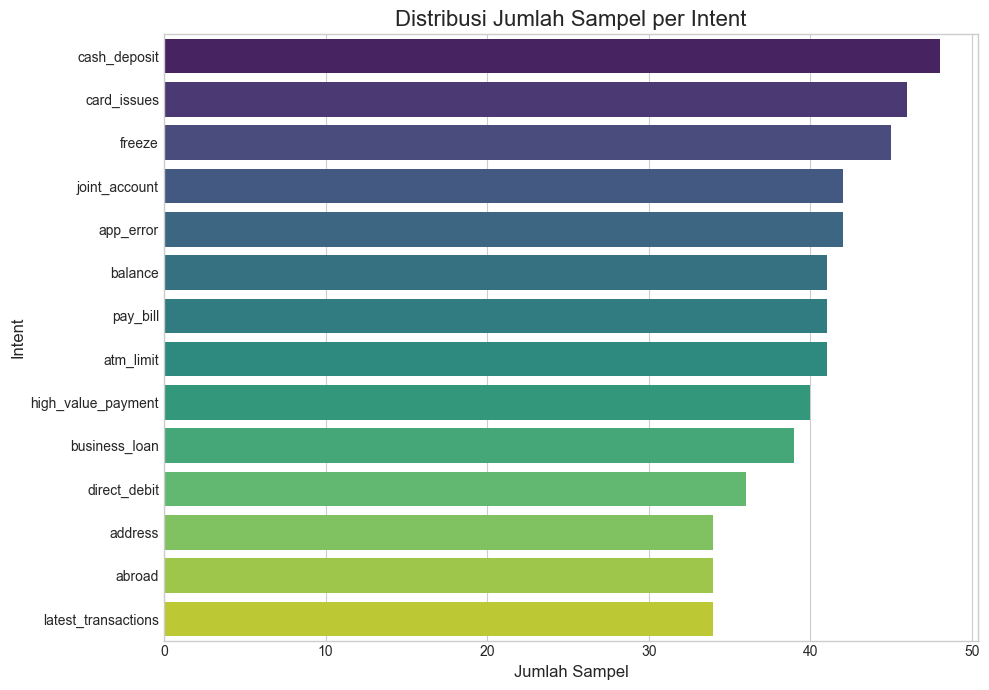

In [5]:
intent_names = dataset.features['intent_class'].names
intent_df = pd.DataFrame({'intent': [intent_names[x] for x in dataset['intent_class']]})

plt.figure(figsize=(10, 7))
sns.countplot(y='intent', data=intent_df, order=intent_df['intent'].value_counts().index, palette='viridis')
plt.title('Distribusi Jumlah Sampel per Intent', fontsize=16)
plt.xlabel('Jumlah Sampel', fontsize=12)
plt.ylabel('Intent', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [6]:
# Ambil sampel acak untuk ditampilkan
random_idx = random.randint(0, len(dataset)-1)
sample = dataset[random_idx]
audio_array = sample['audio']['array']
sr = sample['audio']['sampling_rate']
intent_class = sample['intent_class']
intent_name = dataset.features['intent_class'].names[intent_class]

print(f"Sampel Audio Acak (Index: {random_idx})")
print(f"Intent: {intent_name}")
print(f"Transkripsi: {sample['transcription']}")

print("\nAudio:")
display(Audio(data=audio_array, rate=sr))

# Visualisasi Waveform dan Spectrogram
fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Waveform
librosa.display.waveshow(y=np.array(audio_array, dtype=np.float32), sr=sr, ax=ax[0])
ax[0].set_title('Waveform', fontsize=14)
ax[0].set_ylabel('Amplitudo')

# Spectrogram
S = librosa.feature.melspectrogram(y=np.array(audio_array, dtype=np.float32), sr=sr, n_mels=128, fmax=8000)
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', ax=ax[1], fmax=8000)
fig.colorbar(img, ax=ax[1], format='%+2.0f dB')
ax[1].set_title('Mel-Spectrogram', fontsize=14)
ax[1].set_ylabel('Frekuensi (Hz)')
ax[1].set_xlabel('Waktu (s)')

plt.tight_layout()
plt.show()

Stay tuned...


ModuleNotFoundError: No module named 'torchcodec.decoders'